# DEEP LEARNING WITH PYTHON
## _FROM TABULAR TO MULTIMEDIA_

### UniFr Winter School in Data Analytics & Machine Learning
Fribourg, 14-16 February 2024

with [Christian Kauth](https://www.linkedin.com/in/ckauth/)

# Setup
--> "Runtime" --> "Change runtime type" --> "GPU" hardware accelerator

## Installs

In [ ]:
! pip install -qU tensorflow_datasets

## Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random as random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical


import tensorflow_datasets as tfds

# Eurostat Data

In [ ]:
%%html
<iframe src="https://ec.europa.eu/eurostat/databrowser/view/lan_lcv_ovw/default/table?lang=en" width="1000" height="600"></iframe>

# EuroSAT Dataset
https://www.tensorflow.org/datasets/catalog/eurosat

## Download Data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling eurosat/rgb/2.0.0.incompleteBKWKFR/eurosat-train.tfrecord*...:   0%|          | 0/27000 [00:00<?, ? …

Dataset eurosat downloaded and prepared to ./eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


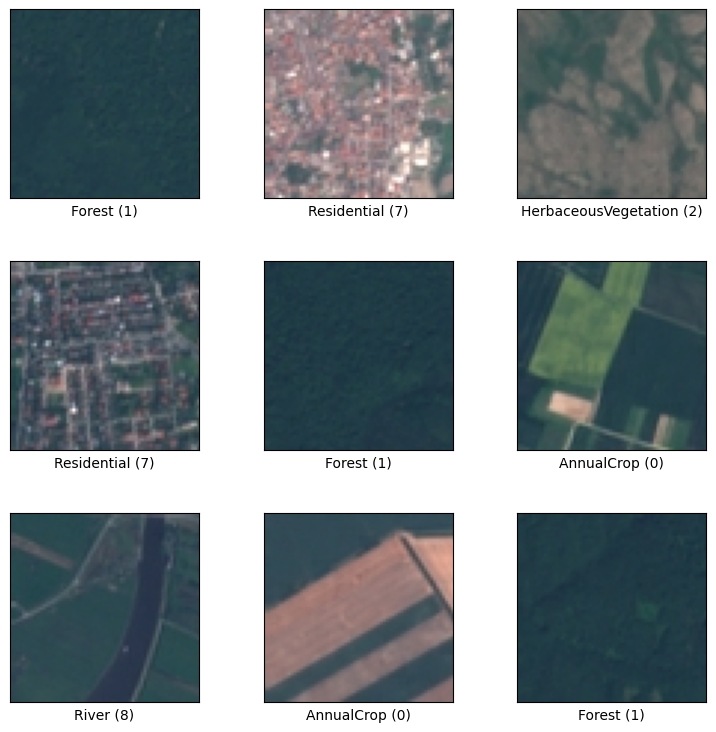

In [ ]:
ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train',
                        data_dir='.')

tfds.show_examples(ds, ds_info);

In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir=PosixGPath('/tmp/tmp_biw9a48tfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('ima

## Load into Pandas

In [ ]:
%%time
df = tfds.as_dataframe(ds, ds_info)
print(df.shape)

(27000, 3)
CPU times: user 14.7 s, sys: 1.97 s, total: 16.7 s
Wall time: 8.42 s


In [ ]:
df.sample(5)

filename  \
2474      b'AnnualCrop_2305.jpg'   
16913      b'Industrial_520.jpg'   
13542     b'Residential_515.jpg'   
23410  b'PermanentCrop_1183.jpg'   
5831          b'Highway_653.jpg'   

                                                   image  label  
2474   [[[152, 145, 137], [157, 144, 136], [182, 157,...      0  
16913  [[[143, 130, 124], [143, 130, 124], [149, 131,...      4  
13542  [[[123, 118, 125], [119, 118, 126], [89, 93, 1...      7  
23410  [[[228, 191, 164], [229, 189, 163], [232, 190,...      6  
5831   [[[84, 92, 105], [83, 92, 107], [77, 90, 107],...      3

## Target Distribution

In [ ]:
df.groupby('label')['label'].value_counts()

label  label
0      0        3000
1      1        3000
2      2        3000
3      3        2500
4      4        2500
5      5        2000
6      6        2500
7      7        3000
8      8        2500
9      9        3000
Name: label, dtype: int64

## Image Dimensions

In [ ]:
df['image'][0].shape

(64, 64, 3)

## Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.stack(df['image'].values),
                                                    np.stack(df['label'].values),
                                                    test_size=0.333333,
                                                    shuffle=True,
                                                    random_state=10)
print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (18000, 64, 64, 3) (18000,)
Test:  (9000, 64, 64, 3) (9000,)


## OneHot Encode the Label

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

In [ ]:
print(y_train.shape, y_test.shape)
print(y_train[:4])

(18000, 10) (9000, 10)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


# Transfer Learning

- A pretrained base for feature extraction
- A custom head for classification

## Big Data

In [ ]:
%%html
<iframe src="https://image-net.org/about.php" width="1000" height="600"></iframe>

<img src="https://machinelearningmastery.com/wp-content/uploads/2017/08/Sample-of-Images-from-the-ImageNet-Dataset-used-in-the-ILSVRC-Challenge.png"/>

<img src="https://www.researchgate.net/profile/Krishna-Kandarpa-2/publication/332452649/figure/fig1/AS:770098897887234@1560617293964/Error-rates-on-the-ImageNet-Large-Scale-Visual-Recognition-Challenge-Accuracy.ppm" width="800px"/>

## Oxford's [VGG](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

### Pretrained Base


In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16()
model.summary()

553467096/553467096 [==============================] - 25s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

### Headless & Customized VGG

In [ ]:
model_base = VGG16(include_top=False, # this is only available for the VGG16 model!
                   pooling='avg', # good practice
                   input_tensor=layers.Input(shape=(64, 64, 3)))
model_base.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

### New Head

In [ ]:
def vgg():
  model_base.trainable = False # don't train the VGG base!! Only train the next part

  model = keras.Sequential([
      model_base,
      layers.Flatten(),
      layers.Dense(128, activation='relu', name='dense_1'),
      layers.Dropout(0.5, name='drop_1'),
      layers.Dense(64, activation='relu', name='dense_2'),
      layers.Dropout(0.5, name='drop_2'),
      layers.Dense(10, activation='softmax', name='output')
  ])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = vgg()
#model.summary(expand_nested=True)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 drop_1 (Dropout)            (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 drop_2 (Dropout)            (None, 64)                0         
                                                                 
 output (Dense)              (None, 10)                6

only 74570 parameters to train!

### Prepare Data
Pixel scaling is performed in a way that was performed to images in the training dataset when the model was developed.

In [ ]:
from keras.applications.vgg16 import preprocess_input

X_train, X_test, y_train, y_test = train_test_split(np.stack(df['image'].values),
                                                    np.stack(df['label'].values),
                                                    test_size=0.333333,
                                                    shuffle=True,
                                                    random_state=10)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Train Model

In [ ]:
%%time
model = vgg()

early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
60/60 [==============================] - 27s 277ms/step - loss: 3.5346 - accuracy: 0.2894 - val_loss: 1.2132 - val_accuracy: 0.6619
Epoch 2/100
60/60 [==============================] - 7s 112ms/step - loss: 1.5187 - accuracy: 0.4997 - val_loss: 0.8137 - val_accuracy: 0.7896
Epoch 3/100
60/60 [==============================] - 6s 107ms/step - loss: 1.1398 - accuracy: 0.6420 - val_loss: 0.5952 - val_accuracy: 0.8411
Epoch 4/100
60/60 [==============================] - 6s 105ms/step - loss: 0.9237 - accuracy: 0.7175 - val_loss: 0.5059 - val_accuracy: 0.8637
Epoch 5/100
60/60 [==============================] - 6s 104ms/step - loss: 0.7884 - accuracy: 0.7619 - val_loss: 0.4452 - val_accuracy: 0.8744
Epoch 6/100
60/60 [==============================] - 6s 103ms/step - loss: 0.6955 - accuracy: 0.7932 - val_loss: 0.4221 - val_accuracy: 0.8830
Epoch 7/100
60/60 [==============================] - 6s 102ms/step - loss: 0.6307 - accuracy: 0.8139 - val_loss: 0.3925 - val_accuracy: 0.890

### Evaluate Model Performance

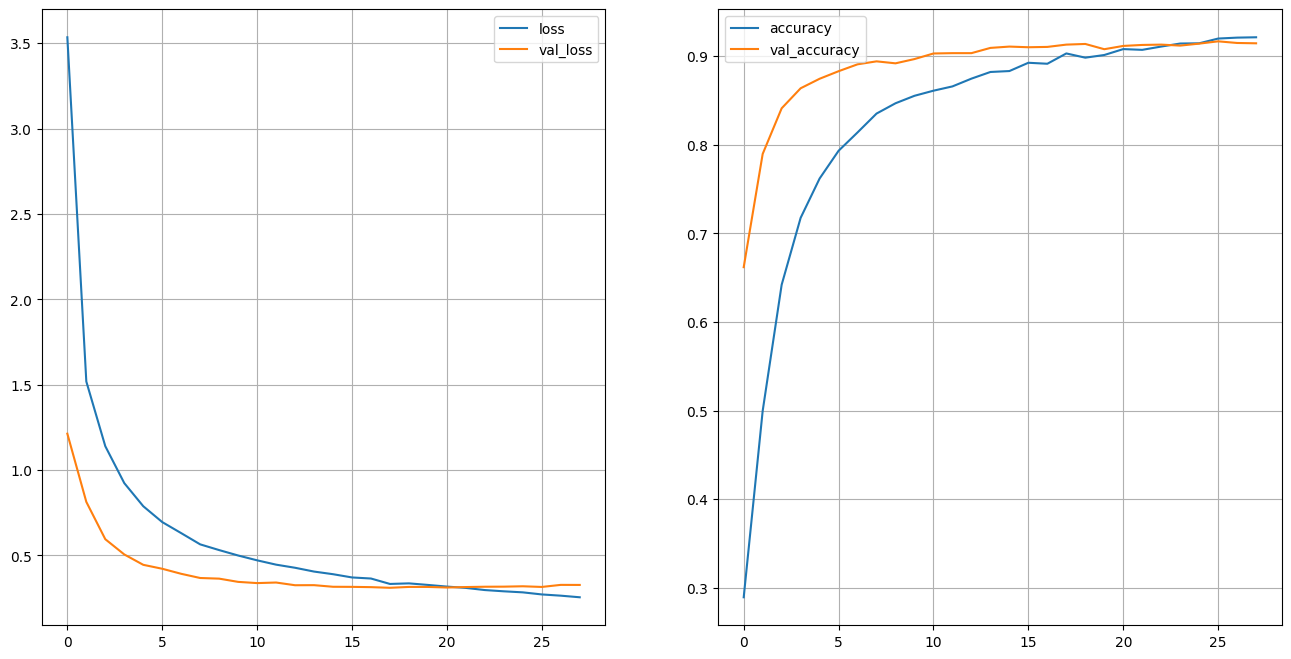

VGG Error: 9.01%


In [ ]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("VGG Error: %.2f%%" % (100-scores[1]*100))

## Google's [Inception](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202)

<img src="https://miro.medium.com/max/1024/1*cwR_ezx0jliDvVUV6yno5g.jpeg"/>

### Pretrained Base

In [ ]:
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3()
model.summary()

96112376/96112376 [==============================] - 6s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

### Headless & Customized Inception

In [ ]:
model_base = InceptionV3(include_top=False,
                         pooling='avg',
                         input_tensor=layers.Input(shape=(128, 128, 3)))
model_base.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 63, 63, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 63, 63, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activa

### New Head

In [ ]:
def inception():
  model_base.trainable = False

  model = keras.Sequential([
      model_base,
      layers.Flatten(),
      layers.Dense(128, activation='relu', name='dense_1'),
      layers.Dropout(0.5, name='drop_1'),
      layers.Dense(64, activation='relu', name='dense_2'),
      layers.Dropout(0.5, name='drop_2'),
      layers.Dense(10, activation='softmax', name='output')
  ])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = inception()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               262272    
                                                                 
 drop_1 (Dropout)            (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 drop_2 (Dropout)            (None, 64)                0         
                                                                 
 output (Dense)              (None, 10)               

### Prepare Data
- Upscale the images for the inception architecture "to make sense".
- Pixel scaling is performed in a way that was performed to images in the training dataset when the model was developed.

In [ ]:
from keras.applications.inception_v3 import preprocess_input # to prepare the image in the same way that google prepare it
# here, the preprocessing unit is included in the package!

X_train, X_test, y_train, y_test = train_test_split(np.stack(df['image'].values),
                                                    np.stack(df['label'].values),
                                                    test_size=0.333333,
                                                    shuffle=True,
                                                    random_state=10)

X_train = preprocess_input(X_train).repeat(2, axis=1).repeat(2, axis=2)
X_test = preprocess_input(X_test).repeat(2, axis=1).repeat(2, axis=2)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (18000, 128, 128, 3) (18000, 10)
Test:  (9000, 128, 128, 3) (9000, 10)


### Train Model

In [ ]:
%%time
model = inception()

early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
60/60 [==============================] - 33s 375ms/step - loss: 1.9422 - accuracy: 0.3283 - val_loss: 1.1331 - val_accuracy: 0.6644
Epoch 2/100
60/60 [==============================] - 11s 188ms/step - loss: 1.3253 - accuracy: 0.5529 - val_loss: 0.8129 - val_accuracy: 0.7774
Epoch 3/100
60/60 [==============================] - 11s 184ms/step - loss: 1.1026 - accuracy: 0.6476 - val_loss: 0.7034 - val_accuracy: 0.8163
Epoch 4/100
60/60 [==============================] - 11s 181ms/step - loss: 0.9676 - accuracy: 0.6916 - val_loss: 0.6167 - val_accuracy: 0.8293
Epoch 5/100
60/60 [==============================] - 11s 180ms/step - loss: 0.9015 - accuracy: 0.7142 - val_loss: 0.5836 - val_accuracy: 0.8389
Epoch 6/100
60/60 [==============================] - 11s 181ms/step - loss: 0.8335 - accuracy: 0.7363 - val_loss: 0.5518 - val_accuracy: 0.8489
Epoch 7/100
60/60 [==============================] - 11s 184ms/step - loss: 0.7835 - accuracy: 0.7493 - val_loss: 0.5383 - val_accuracy:

### Evaluate Model Performance

In [ ]:
del X_train

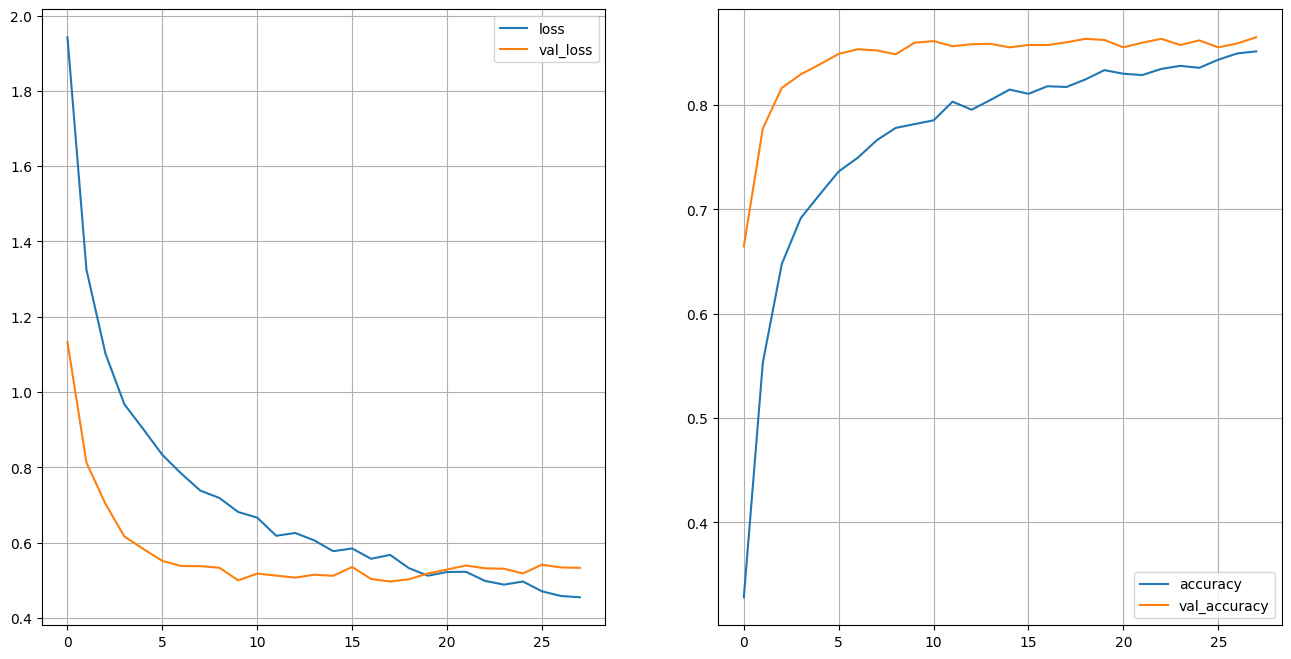

Inception Error: 13.94%


In [ ]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("Inception Error: %.2f%%" % (100-scores[1]*100))

## Microsoft's [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network)

### Pretrained Base

In [ ]:
from keras.applications.resnet import ResNet50
model = ResNet50()
model.summary()

102967424/102967424 [==============================] - 6s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

### Headless & Customized ResNet

In [ ]:
model_base = ResNet50(include_top=False,
                      pooling='avg',
                      input_tensor=layers.Input(shape=(128, 128, 3)))
model_base.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

### New Head

In [ ]:
def resnet():
  model_base.trainable = False

  model = keras.Sequential([
      model_base,
      layers.Flatten(),
      layers.Dense(128, activation='relu', name='dense_1'),
      layers.Dropout(0.5, name='drop_1'),
      layers.Dense(64, activation='relu', name='dense_2'),
      layers.Dropout(0.5, name='drop_2'),
      layers.Dense(10, activation='softmax', name='output')
  ])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
resnet().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               262272    
                                                                 
 drop_1 (Dropout)            (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 drop_2 (Dropout)            (None, 64)                0         
                                                                 
 output (Dense)              (None, 10)                6

### Prepare Data

In [ ]:
from keras.applications.resnet import preprocess_input

X_train, X_test, y_train, y_test = train_test_split(np.stack(df['image'].values),
                                                    np.stack(df['label'].values),
                                                    test_size=0.333333,
                                                    shuffle=True,
                                                    random_state=10)

X_train = preprocess_input(X_train).repeat(2, axis=1).repeat(2, axis=2)
X_test = preprocess_input(X_test).repeat(2, axis=1).repeat(2, axis=2)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (18000, 128, 128, 3) (18000, 10)
Test:  (9000, 128, 128, 3) (9000, 10)


### Train Model

In [ ]:
%%time
model = resnet()

early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
60/60 [==============================] - 34s 400ms/step - loss: 1.3924 - accuracy: 0.5453 - val_loss: 0.3336 - val_accuracy: 0.9159
Epoch 2/100
60/60 [==============================] - 15s 259ms/step - loss: 0.5983 - accuracy: 0.8193 - val_loss: 0.2236 - val_accuracy: 0.9367
Epoch 3/100
60/60 [==============================] - 16s 259ms/step - loss: 0.4328 - accuracy: 0.8747 - val_loss: 0.1922 - val_accuracy: 0.9426
Epoch 4/100
60/60 [==============================] - 16s 262ms/step - loss: 0.3551 - accuracy: 0.8974 - val_loss: 0.1781 - val_accuracy: 0.9474
Epoch 5/100
60/60 [==============================] - 16s 265ms/step - loss: 0.3043 - accuracy: 0.9113 - val_loss: 0.1606 - val_accuracy: 0.9496
Epoch 6/100
60/60 [==============================] - 16s 267ms/step - loss: 0.2690 - accuracy: 0.9222 - val_loss: 0.1630 - val_accuracy: 0.9489
Epoch 7/100
60/60 [==============================] - 16s 273ms/step - loss: 0.2401 - accuracy: 0.9305 - val_loss: 0.1528 - val_accuracy:

### Evaluate Model Performance

In [ ]:
del X_train

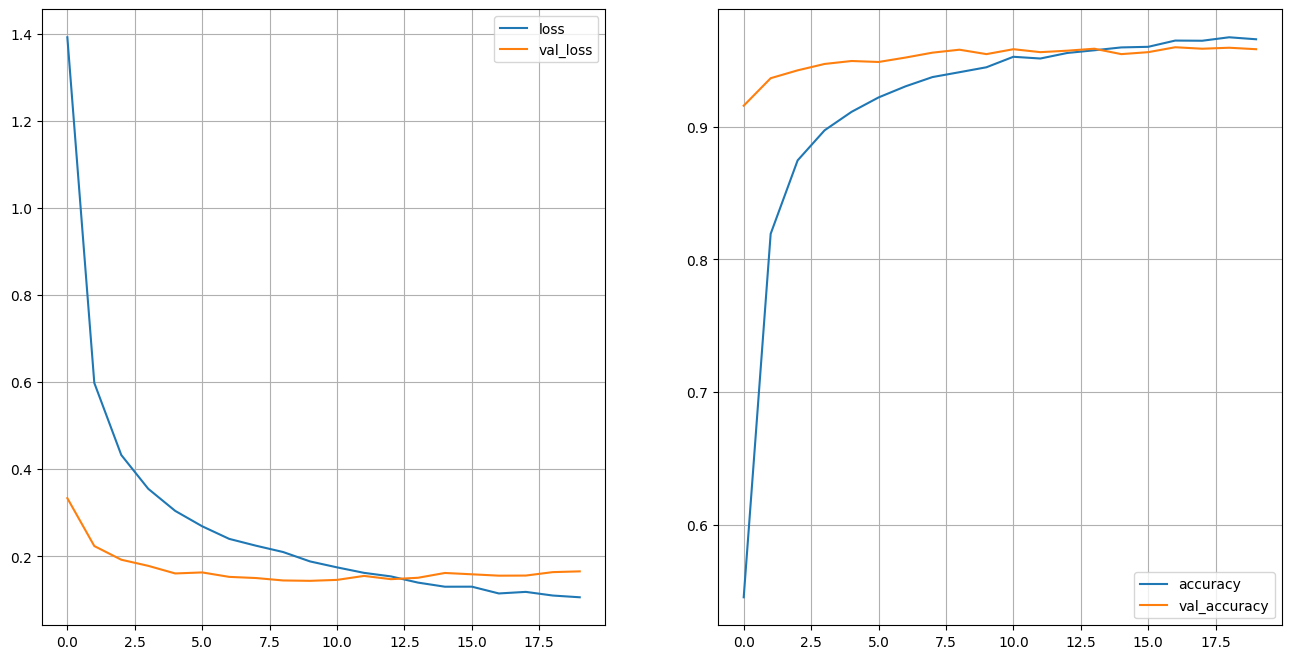

Inception Error: 4.96%


In [ ]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("Inception Error: %.2f%%" % (100-scores[1]*100))

# Deployment

## Create Examples

In [ ]:
from PIL import Image
import os

os.makedirs('satellite_classifier')

for i in range(20):
  im = Image.fromarray(df['image'].sample(1).values[0])
  im.save(f"satellite_classifier/example{str(i).zfill(2)}.png")

## Save all you need
- the examples
- the trained model

In [ ]:
model.save('satellite_classifier/model')

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive', force_remount=True)
model_dir = os.path.join('gdrive', 'MyDrive', 'UniFr', 'Winter School 2024', 'Python - DL')

Mounted at /content/gdrive


In [ ]:
!zip -rq satellite_classifier.zip satellite_classifier
!cp satellite_classifier.zip "$model_dir"

# Gradio

## Load all you need
or reuse what you've trained
- examples
- trained model

In [ ]:
!wget https://kauthentechstorage.blob.core.windows.net/models/satellite_classifier.zip -P satellite_classifier

--2024-02-15 05:02:29--  https://kauthentechstorage.blob.core.windows.net/models/satellite_classifier.zip
Resolving kauthentechstorage.blob.core.windows.net (kauthentechstorage.blob.core.windows.net)... 52.239.140.42
Connecting to kauthentechstorage.blob.core.windows.net (kauthentechstorage.blob.core.windows.net)|52.239.140.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90912790 (87M) [application/x-zip-compressed]
Saving to: ‘satellite_classifier/satellite_classifier.zip’

satellite_classifie 100%[===================>]  86.70M  11.6MB/s    in 10s     

2024-02-15 05:02:41 (8.34 MB/s) - ‘satellite_classifier/satellite_classifier.zip’ saved [90912790/90912790]



In [ ]:
!unzip -q satellite_classifier/satellite_classifier.zip

replace satellite_classifier/example02.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 10.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into accou

In [ ]:
import gradio as gr
import numpy as np
from keras.applications.resnet import preprocess_input
from tensorflow import keras

model = keras.models.load_model('satellite_classifier/model')
labels = ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'SeaLake']


def classify_image(img):
  img = img.reshape((-1, 64, 64, 3))
  img = preprocess_input(img).repeat(2, axis=1).repeat(2, axis=2)

  prediction = model.predict(img)[0]
  confidences = {labels[i]: float(prediction[i]) for i in range(10)}
  return confidences


demo = gr.Interface(fn=classify_image,
                    inputs=gr.Image(width=400, height=400),
                    outputs=gr.Label(num_top_classes=3),
                    examples=[f"satellite_classifier/example{str(i).zfill(2)}.png" for i in range(20)])

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5c7dc3429d9ddae074.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# UP NEXT
[Vision AIs](https://colab.research.google.com/drive/1vXDjNkU8uTKKsyirQA4eGeux_YDy8A9L?usp=sharing)